실습예제

In [ ]:
#오존량 예측

import pandas as pd
df=pd.read_csv('d:/data/ozone/ozone4.csv')
df.head()

In [ ]:
df['Result'].value_counts() #0/1 카운트

In [ ]:
df.columns

In [ ]:
train_cols=['Solar.R2','Wind','Temp']
X=df[train_cols] #독립변수
y=df['Result'] #종속변수

In [ ]:
#오버샘플링 
from imblearn.over_sampling import SMOTE
X_sample,y_sample=SMOTE(random_state=0).fit_sample(X,y)
X_samp=pd.DataFrame(data=X_sample, columns=train_cols)
y_samp=pd.DataFrame(data=y_sample, columns=['Result'])
df_samp=pd.concat([X_samp,y_samp],axis=1)

In [ ]:
df_samp['Result'].value_counts()

In [ ]:
X=X_samp[train_cols]
y=y_samp['Result']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,stratify=y,
                                                 test_size=0.2,random_state=10)

In [ ]:
#인공신경망 모형
from keras.models import Sequential
from keras.layers.core import Dense,Dropout

model=Sequential()
#input_layer(입력층) input_shape=(독립변수갯수,)
model.add(Dense(128,input_shape=(len(X_train.columns),),activation='relu',name='input'))
#hidden layers(은닉층) 출력노드수, 활성화 함수
model.add(Dense(64, activation='relu',name='hidden1'))
model.add(Dense(32, activation='relu',name='hidden2'))
model.add(Dense(16, activation='relu',name='hidden3'))
model.add(Dense(8, activation='relu',name='hidden4'))
#Dropout(p) p확률로 출력노드에 보내는 신호를 조절, 과적합방지를 위해사용
model.add(Dropout(0.2,name='dropout')) #드롭아웃 계층
model.add(Dense(1, activation='sigmoid',name='output'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()

In [ ]:
X_train.boxplot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler() #0~1 정규화를 처리하는 함수
# 데이터를 입력하여 0~1정규화 수행
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [ ]:
df3=pd.DataFrame(X_train_scaled,columns=train_cols)
df3.boxplot() #스케일링 후의 박스플롯(0~1 정규화 수행)

In [ ]:
#학습
hist=model.fit(X_train_scaled, y_train,epochs=500,validation_split=0.2)

In [ ]:
#정확도 평가
scores=model.evaluate(X_train_scaled,y_train)
print(scores)
scores=model.evaluate(X_test_scaled,y_test)
print(scores)

In [ ]:
#새로운 값 예측 (스케일전)
import numpy as np
#일조량 25, 풍량 10.8 화씨온도 71일 때의 오존량 예측
test_set=np.array([25,10.8,71]).reshape(1,3)
print(model.predict(test_set)) #1일 확률 0%

#일조량 255, 풍량 4.3, 화씨온도 90일 때의 오존량 예측
test_set=np.array([255,4.3,90]).reshape(1,3)
print(model.predict(test_set)) #1일 확률 91.3%

In [ ]:
#새로운 값 예측 (스케일후)
import numpy as np
#일조량 25, 풍량 10.8 화씨온도 71일 때의 오존량 예측
test_set=np.array([25,10.8,71]).reshape(1,3)
#새로운 입력값을 MinMAxScaler를 이용하여 변환
test_set_scaled=scaler.transform(test_set)
print(model.predict(test_set_scaled)) #1일 확률 0%

#일조량 255, 풍량 4.3, 화씨온도 90일 때의 오존량 예측
test_set=np.array([255,4.3,90]).reshape(1,3)
test_set_scaled=scaler.transform(test_set)
print(model.predict(test_set_scaled)) #1일 확률 99.9%

In [ ]:
# joblib 패키지를 이용하여 MinMaxScaler의 결과값을 백업
import joblib
joblib.dump(scaler, 'd:/data/ozone/scaler.sav')

In [ ]:
#keras 모형 저장
model.save('d:/data/ozone/ozone_keras.model')
#학습에 사용된 가중치 저장
model.save_weights('d:/data/ozone/ozone.weights')

In [ ]:
#손글씨 데이터셋(mnist)

In [ ]:
from keras import datasets
from keras.utils import np_utils
#손글씨 숫자 이미지 데이터셋 다운로드, 학습용/검증용 구분
(X_train,y_train),(X_test,y_test)=datasets.mnist.load_data()
#print(X_train[0])
#print(y_test[0])
#출력 노드 갯수가 10개(0~9)이므로 종속변수를 원핫인코딩 처리
y_train=np_utils.to_categorical(y_train)
y_test=np_utils.to_categorical(y_test)
print(y_train[:5])
print(X_train.shape) #학습용 6만장
print(X_test.shape) #검증용 1만장
L,W,H=X_train.shape #이미지의 차원
X_train=X_train.reshape(-1,W*H) #2차원으로 변환, -1 숫자미정, 28x28
X_test=X_test.reshape(-1,W*H)
X_train=X_train / 255.0
X_test=X_test /255.0
print(X_train[0])

In [ ]:
from keras import layers,models
#신경망을 만드는 함수
def make_model(input_number,hidden_layers,output_number):
    model=models.Sequential() #모형 초기화
    
    model.add(layers.Dense(hidden_layers[0],activation='relu',input_shape=(input_number,),name='input_layer'))
    
    model.add(layers.Dense(hidden_layers[1],activation='relu',name='hidden_layer1'))
    
    model.add(layers.Dense(hidden_layers[2],activation='relu',name='hidden_layer2'))
    
    #드롭아웃 계층, 과적합을 방지하기 위하여 사용 출력값 20% 누락시킴
    model.add(layers.Dropout(0.2,name='dropout'))
    #출력층, 활성화함수는 소프트맥스 사용
    model.add(layers.Dense(output_number,activation='softmax',name='output_layer'))
    #모형 컴파일, 손실함수와 최적화함수, 측정지표 설정
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

input_number=784 #입력층의 노드수(28x28=784 픽셀) - 독립변수의 갯수
hidden_layers=[128,64,32] #은닉층의 출력노드 갯수
number_of_class=10 #출력층의 노드 갯수(0~9)
output_number=number_of_class
#모형을 만들고
model=make_model(input_number, hidden_layers, output_number)
model.summary() #모형의 요약 정보 출력

In [ ]:
#학습과정
hist = model.fit(X_train,y_train, epochs=10, batch_size=100,
                validation_split=0.2)

In [ ]:
#모형평가
performance_train = model.evaluate(X_train,y_train,batch_size=100)
#print(performance_train)
print('loss','accuracy:',performance_train)

performance_test = model.evaluate(X_test,y_test,batch_size=100)
print('loss','accuracy:',performance_test)


In [ ]:
#손실률,정확도 그래프
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','accuracy','val_loss','val_accuracy'])
plt.grid()
plt.show()

In [ ]:
import numpy as np
#예측
# pred = model.predict_classes(X_test[0].reshape(1,784))
# print(pred)
# print(y_test[0])
for i in range(10):
    pred=model.predict_classes(X_test[i].reshape(1,784))
    print(np.argmax(y_test[i]),'==>',pred[0])

In [ ]:
#신용카드거래

In [ ]:
import pandas as pd
df=pd.read_csv('d:/data/creditcard/creditcard.csv')
df.head()

In [ ]:
df['Class'].value_counts()

In [ ]:
train_cols=df.columns[1:29]
X=df[train_cols]
y=df['Class']

In [ ]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample,y_sample=RandomUnderSampler(random_state=0).fit_sample(X,y)
X_samp=pd.DataFrame(data=X_sample,columns=train_cols)
y_samp=pd.DataFrame(data=y_sample,columns=['Class'])
df2=pd.concat([X_samp,y_samp],axis=1)

In [ ]:
df2['Class'].value_counts() #샘플링 후의 0/1 zkdnsxm

In [ ]:
X=df2[train_cols]
y=df2['Class']

In [ ]:
#학습용:검증용 8:2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=10)

In [ ]:
from keras import layers,models
#신경망을 만드는 함수
def make_model(input_number,hidden_layers,output_number):
    model=models.Sequential() #모형 초기화
    
    model.add(layers.Dense(hidden_layers[0],activation='relu',input_shape=(input_number,),name='input_layer'))
    
    model.add(layers.Dense(hidden_layers[1],activation='relu',name='hidden_layer1'))
    
    model.add(layers.Dense(hidden_layers[2],activation='relu',name='hidden_layer2'))
    
    #드롭아웃 계층, 과적합을 방지하기 위하여 사용 출력값 20% 누락시킴
    model.add(layers.Dropout(0.2,name='dropout'))
    #출력층, 활성화함수는 sigmoid 사용
    model.add(layers.Dense(output_number,activation='sigmoid',name='output_layer'))
    #모형 컴파일, 손실함수와 최적화함수, 측정지표 설정
    model.compile(loss='mse',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [ ]:
# make_model(입력노드수,은닉노드수,출력노드수)
model=make_model(len(X_train.columns),[128,64,32],1)
model.summary() #모형 요약정보 출력

In [ ]:
#학습과정
hist = model.fit(X_train,y_train, epochs=500, batch_size=16,
                validation_split=0.2)

In [ ]:
#모형평가
performance_train = model.evaluate(X_train,y_train,batch_size=16)
#print(performance_train)
print('loss','accuracy:',performance_train)

performance_test = model.evaluate(X_test,y_test,batch_size=16)
print('loss','accuracy:',performance_test)


In [ ]:
#손실률,정확도 그래프
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','accuracy','val_loss','val_accuracy'])
plt.grid()
plt.show()

In [ ]:
#sigmoid의 예측값은 0.0~1.0으로 출력됨
pred=model.predict(X_test[:10])
print(pred)
print(y_test[:10].values)


for i in range(10):
    result=pred[i]
    print(y_test.values[i],'==>','{:.2f}'.format(result[0]))

In [ ]:
#bmi 분류

In [ ]:
import pandas as pd
df=pd.read_csv('d:/data/bmi/bmi.csv')
df.head()

In [ ]:
df['label'].value_counts()

In [ ]:
train_cols=df.columns[0:2]
X=df[train_cols] #독립변수
y=df['label'] #종속변수
X.head() 

In [ ]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample,y_sample=RandomUnderSampler(random_state=0).fit_sample(X,y)
X_samp=pd.DataFrame(data=X_sample,columns=train_cols)
y_samp=pd.DataFrame(data=y_sample,columns=['label'])
df2=pd.concat([X_samp,y_samp],axis=1)

In [ ]:
df2['label'].value_counts()

In [ ]:
y[:10].values

In [ ]:
#종속변수를 원핫인코딩 처리
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y1=encoder.fit_transform(y)
y2=pd.get_dummies(y1).values
y2[:10]

In [ ]:
#학습용:검증용 8:2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y2,test_size=0.2,stratify=y,random_state=10)

In [ ]:
from keras import layers,models
#신경망을 만드는 함수
def make_model(input_number,hidden_layers,output_number):
    model=models.Sequential() #모형 초기화
    
    model.add(layers.Dense(hidden_layers[0],activation='relu',input_shape=(input_number,),name='input_layer'))
    
    model.add(layers.Dense(hidden_layers[1],activation='relu',name='hidden_layer1'))
    
    model.add(layers.Dense(hidden_layers[2],activation='relu',name='hidden_layer2'))
    
    #model.add(layers.Dense(hidden_layers[2],activation='relu',name='hidden_layer3'))
    
    #드롭아웃 계층, 과적합을 방지하기 위하여 사용 출력값 20% 누락시킴
    model.add(layers.Dropout(0.2,name='dropout'))
    #출력층, 활성화함수는 sigmoid 사용
    model.add(layers.Dense(output_number,activation='softmax',name='output_layer'))
    #모형 컴파일, 손실함수와 최적화함수, 측정지표 설정
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [ ]:
# make_model(입력노드수,은닉노드수,출력노드수)
model=make_model(len(X_train.columns),[128,64,32],3)
model.summary() #모형 요약정보 출력

In [ ]:
#학습과정
hist = model.fit(X_train,y_train, epochs=10, batch_size=10,
                validation_split=0.2)

In [ ]:
#모형평가
performance_train = model.evaluate(X_train,y_train,batch_size=10)
#print(performance_train)
print('loss','accuracy:',performance_train)

performance_test = model.evaluate(X_test,y_test,batch_size=10)
print('loss','accuracy:',performance_test)


In [ ]:
#손실률,정확도 그래프
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','accuracy','val_loss','val_accuracy'])
plt.grid()
plt.show()

In [ ]:
X_test.iloc[0]

In [ ]:
X_test

In [ ]:
import numpy as np
#예측
pred = model.predict_classes(X_test)
print(pred[:10])
print(y_test[:10])
# for i in X_test.iloc[:,:]:
#     print(i)
    #pred=model.predict_classes(i)
    #print(np.argmax(y_test[i]),'==>',pred[i])

In [ ]:
#놀이기구만족도

In [1]:
import pandas as pd
df=pd.read_csv('d:/data/rides/rides2.csv')
df.head()

,weekend,num.child,distance,rides,games,wait,clean,overall,class
0,1,0,114.648259,87,73,60,89,47,0
1,1,2,27.014097,87,78,76,87,65,1
2,0,1,63.300975,85,80,70,88,61,1
3,1,0,25.909931,88,72,66,89,37,0
4,0,4,54.718307,84,87,74,87,68,1


In [2]:
df.columns

Index(['weekend', 'num.child', 'distance', 'rides', 'games', 'wait', 'clean',
       'overall', 'class'],
      dtype='object')

In [3]:
train_cols=['weekend', 'num.child', 'distance', 'rides', 'games', 'wait', 'clean']
X=df[train_cols] #독립변수
y=df['class']#종속변수

In [4]:
df['class'].value_counts() #언더 샘플링 전의 0,1 카운트

0    262
1    238
Name: class, dtype: int64

In [5]:
#언더 샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample, y_sample=RandomUnderSampler(random_state=0).fit_sample(X,y)
X_samp=pd.DataFrame(data=X_sample, columns=train_cols)
y_samp=pd.DataFrame(data=y_sample,columns=['class'])
df_samp=pd.concat([X_samp,y_samp],axis=1)

Using TensorFlow backend.


In [6]:
df_samp['class'].value_counts() #언더 샘플링 후의 0,1 카운트

1    238
0    238
Name: class, dtype: int64

In [7]:
X=df_samp[train_cols]
y=df_samp['class']

In [8]:
#학습용:검증용 8:2로 구분
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              stratify=y,random_state=10)

In [9]:
#신경망 모형을 만드는 함수
from keras.models import Sequential
from keras.layers.core import Dense,Dropout
def make_model(input_number, hidden_layers, output_number):
    model=Sequential()
    model.add(Dense(hidden_layers[0],activation='relu',
                   input_shape=(input_number,), name='Input-layer-1'))
    model.add(Dense(hidden_layers[1],activation='relu',
                   name='Hidden-layer-2'))
    model.add(Dense(hidden_layers[2],activation='relu',
                   name='Hidden-layer-3'))
    model.add(Dropout(0.2,name='Dropout')) #드롭아웃(출력값 조절)
    model.add(Dense(output_number, activation='sigmoid',
                   name='Output-layer')) #출력층
    #모형 컴파일, 손실함수와 최적화함수, 측정항목 설정
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model
    
    

In [10]:
X_train.columns

Index(['weekend', 'num.child', 'distance', 'rides', 'games', 'wait', 'clean'], dtype='object')

In [11]:
len(X_train.columns)

7

In [12]:
#모형을 만들고 모형의 요약정보 출력
#make_model(입력노드갯수, 출력노드갯수,최종결과노드수)
model=make_model(len(X_train.columns),[128,64,32],1)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input-layer-1 (Dense)        (None, 128)               1024      
_________________________________________________________________
Hidden-layer-2 (Dense)       (None, 64)                8256      
_________________________________________________________________
Hidden-layer-3 (Dense)       (None, 32)                2080      
_________________________________________________________________
Dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Output-layer (Dense)         (None, 1)                 33        
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0
_________________________________________________________________


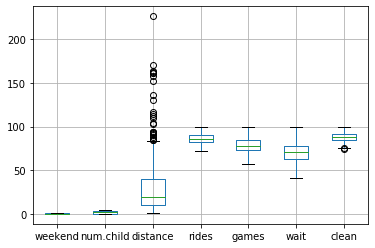

In [13]:
%matplotlib inline 
X_train.boxplot() #0~1 정규화 전의 박스 플롯

In [14]:
# 0~1 정규화 처리
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

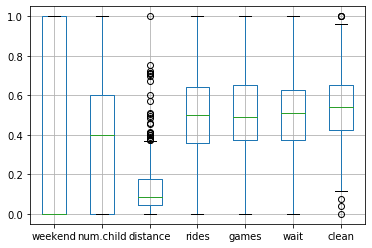

In [15]:
df3=pd.DataFrame(X_train_scaled, columns=train_cols)
df3.boxplot() #정규화 후의 박스플롯

In [16]:
#학습 
hist=model.fit(X_train_scaled, y_train, epochs=500,
              validation_split=0.2)

Train on 304 samples, validate on 76 samples
Epoch 1/500
304/304 [==============================] - 0s 656us/step - loss: 0.2462 - accuracy: 0.5197 - val_loss: 0.2392 - val_accuracy: 0.5921
Epoch 2/500
304/304 [==============================] - 0s 46us/step - loss: 0.2344 - accuracy: 0.5855 - val_loss: 0.2332 - val_accuracy: 0.6316
Epoch 3/500
304/304 [==============================] - 0s 43us/step - loss: 0.2248 - accuracy: 0.6316 - val_loss: 0.2259 - val_accuracy: 0.6447
Epoch 4/500
304/304 [==============================] - 0s 43us/step - loss: 0.2144 - accuracy: 0.6678 - val_loss: 0.2167 - val_accuracy: 0.5789
Epoch 5/500
304/304 [==============================] - 0s 43us/step - loss: 0.2018 - accuracy: 0.7368 - val_loss: 0.2035 - val_accuracy: 0.6974
Epoch 6/500
304/304 [==============================] - 0s 43us/step - loss: 0.1897 - accuracy: 0.7401 - val_loss: 0.1949 - val_accuracy: 0.7368
Epoch 7/500
304/304 [==============================] - 0s 46us/step - loss: 0.1807 - accur

304/304 [==============================] - 0s 43us/step - loss: 0.0732 - accuracy: 0.9145 - val_loss: 0.1390 - val_accuracy: 0.7895
Epoch 114/500
304/304 [==============================] - 0s 46us/step - loss: 0.0771 - accuracy: 0.8947 - val_loss: 0.1365 - val_accuracy: 0.8026
Epoch 115/500
304/304 [==============================] - 0s 62us/step - loss: 0.0781 - accuracy: 0.8947 - val_loss: 0.1498 - val_accuracy: 0.7895
Epoch 116/500
304/304 [==============================] - 0s 46us/step - loss: 0.0809 - accuracy: 0.8914 - val_loss: 0.1374 - val_accuracy: 0.7895
Epoch 117/500
304/304 [==============================] - 0s 46us/step - loss: 0.0826 - accuracy: 0.8914 - val_loss: 0.1442 - val_accuracy: 0.8158
Epoch 118/500
304/304 [==============================] - 0s 56us/step - loss: 0.0747 - accuracy: 0.8914 - val_loss: 0.1450 - val_accuracy: 0.7895
Epoch 119/500
304/304 [==============================] - 0s 49us/step - loss: 0.0744 - accuracy: 0.9112 - val_loss: 0.1394 - val_accuracy:

304/304 [==============================] - 0s 43us/step - loss: 0.0463 - accuracy: 0.9441 - val_loss: 0.1479 - val_accuracy: 0.8026
Epoch 226/500
304/304 [==============================] - 0s 43us/step - loss: 0.0401 - accuracy: 0.9539 - val_loss: 0.1426 - val_accuracy: 0.8158
Epoch 227/500
304/304 [==============================] - 0s 49us/step - loss: 0.0400 - accuracy: 0.9605 - val_loss: 0.1430 - val_accuracy: 0.8158
Epoch 228/500
304/304 [==============================] - 0s 52us/step - loss: 0.0397 - accuracy: 0.9572 - val_loss: 0.1491 - val_accuracy: 0.8026
Epoch 229/500
304/304 [==============================] - 0s 49us/step - loss: 0.0526 - accuracy: 0.9276 - val_loss: 0.1412 - val_accuracy: 0.8289
Epoch 230/500
304/304 [==============================] - 0s 46us/step - loss: 0.0465 - accuracy: 0.9441 - val_loss: 0.1459 - val_accuracy: 0.8026
Epoch 231/500
304/304 [==============================] - 0s 46us/step - loss: 0.0455 - accuracy: 0.9441 - val_loss: 0.1491 - val_accuracy:

304/304 [==============================] - 0s 43us/step - loss: 0.0229 - accuracy: 0.9770 - val_loss: 0.1541 - val_accuracy: 0.8289
Epoch 338/500
304/304 [==============================] - 0s 46us/step - loss: 0.0225 - accuracy: 0.9737 - val_loss: 0.1517 - val_accuracy: 0.8421
Epoch 339/500
304/304 [==============================] - 0s 46us/step - loss: 0.0212 - accuracy: 0.9770 - val_loss: 0.1699 - val_accuracy: 0.7895
Epoch 340/500
304/304 [==============================] - 0s 43us/step - loss: 0.0290 - accuracy: 0.9572 - val_loss: 0.1442 - val_accuracy: 0.8553
Epoch 341/500
304/304 [==============================] - 0s 49us/step - loss: 0.0289 - accuracy: 0.9704 - val_loss: 0.1463 - val_accuracy: 0.8421
Epoch 342/500
304/304 [==============================] - 0s 49us/step - loss: 0.0250 - accuracy: 0.9704 - val_loss: 0.1611 - val_accuracy: 0.8026
Epoch 343/500
304/304 [==============================] - 0s 52us/step - loss: 0.0229 - accuracy: 0.9704 - val_loss: 0.1620 - val_accuracy:

304/304 [==============================] - 0s 43us/step - loss: 0.0182 - accuracy: 0.9803 - val_loss: 0.1644 - val_accuracy: 0.8289
Epoch 450/500
304/304 [==============================] - 0s 46us/step - loss: 0.0130 - accuracy: 0.9901 - val_loss: 0.1731 - val_accuracy: 0.8026
Epoch 451/500
304/304 [==============================] - 0s 46us/step - loss: 0.0130 - accuracy: 0.9868 - val_loss: 0.1539 - val_accuracy: 0.8421
Epoch 452/500
304/304 [==============================] - 0s 46us/step - loss: 0.0129 - accuracy: 0.9868 - val_loss: 0.1903 - val_accuracy: 0.7632
Epoch 453/500
304/304 [==============================] - 0s 56us/step - loss: 0.0154 - accuracy: 0.9836 - val_loss: 0.1513 - val_accuracy: 0.8421
Epoch 454/500
304/304 [==============================] - 0s 49us/step - loss: 0.0214 - accuracy: 0.9737 - val_loss: 0.1637 - val_accuracy: 0.8289
Epoch 455/500
304/304 [==============================] - 0s 49us/step - loss: 0.0153 - accuracy: 0.9836 - val_loss: 0.1862 - val_accuracy:

In [23]:
X_train

,weekend,num.child,distance,rides,games,wait,clean
308,1,1,5.045047,92,72,86,94
400,0,3,83.410778,90,73,77,92
45,1,0,28.025316,91,80,86,94
352,0,2,12.732597,87,88,81,85
339,0,2,62.260977,90,82,68,88
...,...,...,...,...,...,...,...
267,0,5,70.904422,83,92,76,93
376,1,3,10.041997,91,77,68,94
105,0,0,47.393754,84,77,62,85
473,0,2,45.177402,95,92,85,93


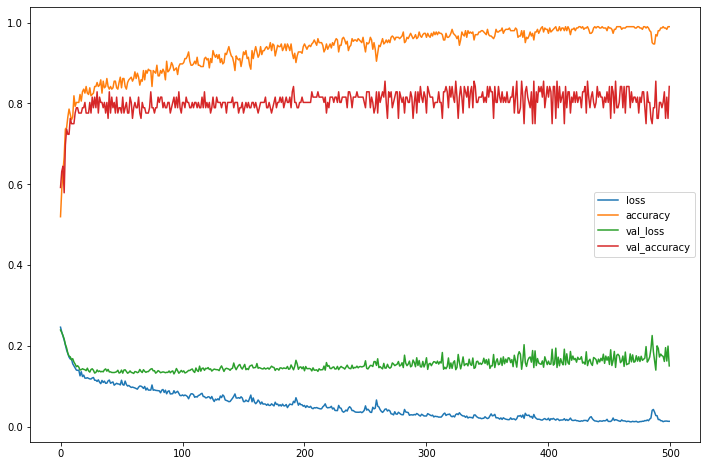

In [17]:
#손실률, 정확도 그래프
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','accuracy','val_loss','val_accuracy'])
plt.legend
plt.show()

In [18]:
#모형평가
scores=model.evaluate(X_train_scaled,y_train, verbose=1)
print(scores)
scores=model.evaluate(X_test_scaled,y_test, verbose=1)
print(scores)

380/380 [==============================] - 0s 18us/step
[0.041268979086491624, 0.9578947424888611]
96/96 [==============================] - 0s 21us/step
[0.1470122088988622, 0.8229166865348816]


In [19]:
#모형저장
model.save('d:/data/rides/rides_keras.model')
model.save_weights('d:/data/rides/rides.weights')

In [20]:
#MinMaxScaler 백업
import joblib
joblib.dump(scaler, 'd:/data/rides/scaler.sav')

['d:/data/rides/scaler.sav']

In [21]:
X_train.columns

Index(['weekend', 'num.child', 'distance', 'rides', 'games', 'wait', 'clean'], dtype='object')

In [25]:
#새로운 값으로 분류 결과 확인
import numpy as np
#평일, 자녀수2, 거리20, 놀이기구점수84, 게임점수 78, 대기점수 67, 청결89
test_set=np.array([0,2,20,84,78,67,89]).reshape(1,7)
test_set_scaled=scaler.transform(test_set)
print(test_set)
print(test_set_scaled)
print(model.predict(test_set_scaled)) #만족(99.2%)

#주말, 자녀수1, 거리 20, 놀이기구점수 55, 게임점수 88, 대기점수 80, 청결 75 
test_set=np.array([1,2,10,55,88,80,75]).reshape(1,7)
test_set_scaled=scaler.transform(test_set)
print(model.predict(test_set_scaled)) #불만족(20.9%)

[[ 0  2 20 84 78 67 89]]
[[0.         0.4        0.07737054 0.41666667 0.47368421 0.46551724
  0.54166667]]
[[0.9998348]]
[[1.]]
